# C-Extensions for faster graph calculations

The primary objective of this notebook is to discuss how to call a C++ function directly from Python code. There are several ways to achieve this, including Python's Ctypes, Swig, Pybind and others. The method you choose is dictated by the production environment and the OS of your workstation as well as the degree of coupling between the two languages that you require. For instance, what data is required to cross the Python-C boundary: plain old data types like integers or bools, or custom classes? For this exercise, we will use Ctypes as it works with minimal effort as long as you have a C++ compiler installed!

We will run a little experiment between a pure Python solution and the C-extension wrapper to see which is faster and how the two approaches scale. 

For our experiment, we will be required to find the largest connected component of a graph that is constructed from an array of unique integers, $N$. There is a node in the graph for each integer in $N$ and an edge between nodes $i$ and $j$ if the two integers share a common factor greater than 1 (see the slides for an example).

There are many clever solutions to this problem that involve some interesting tricks and algorithm design. However, we will implement a brute force solution as our primary objective is to compare Python and C-extensions - we *want* to burn some CPU after all!

The brute force solution constructs a graph in the form of an adjacency list using a dictionary or key-value map datastructure. The edges are added to the dictionary by recursively finding the highest common factor from the input list of integers. With the graph in place, we then perform a depth first search on the graph, keeping track of visited nodes to find the component size of the largest connected component.

Lets begin by implementing a pure Python solution.

In [1]:
from typing import List
from collections import defaultdict
from math import gcd  # greatest common divisor


def recurse(node, adj_list, visited):
    visited.add(node)
    for v in adj_list[node]:
        if v not in visited:
            recurse(v, adj_list, visited)


def dfs(adj_list):

    res, prev = 0, 0
    visited = set()
    for k, _ in adj_list.items():
        if k not in visited:
            recurse(k, adj_list, visited)

        l = len(visited) - prev
        res = max(l, res)
        prev = len(visited)

    return res

def largest_component_size(N: List[int]) -> int:

    adj_list = defaultdict(list)
    for i in range(len(N)):
        for j in range(i + 1, len(N)):

            if gcd(N[i], N[j]) > 1:
                adj_list[N[i]].append(N[j])
                adj_list[N[j]].append(N[i])

    return dfs(adj_list)

Lets not run it against our example from the lecture slides. We expect the largest connected component to contain 4 nodes, whilst nodes 5, 7, 11 and 13 have no edges as they are prime numbers.

In [2]:
N = [2, 4, 5, 6, 7, 11, 12, 13]
print(f"The largest connected component has {largest_component_size(N)} nodes")

The largest connected component has 4 nodes


Next we will consider the same algorithm in C++ by opening the `brute_dfs.cc` file in this directory. I have tried to keep the code as close as possible to the Python implementation in order to faithfully compare the two approaches. Inspecting the .cc file, we see a section on line 85 that is essentially a C-wrapper around the C++ code. 

```C++
extern "C" {

    int largest_component_size(int *array, int length) {
        return _largest_component_size(array, length);
    }
}
```

We have compiled the C++ code to a shared library and included it in this directory for you; however, should you wish to make changes and re-compile it, you can do so with the following two commands

```bash
$ g++ -std=c++17 -Ofast -I ./inc -fpic -c brute_dfs.cc -o brute_dfs.o
$ g++ -shared -o lib_brute_dfs.so brute_dfs.o
```

With the shared library object `lib_brute_dfs.so` compiled, we can now import this using `ctypes.CDLL()` object in Python which takes a path to the `.so` library in its constructor.

In [3]:
# import CDLL and c_int from ctypes
from ctypes import CDLL, c_int

# create a CDLL instance for our extension
path_to_so_file = "./lib_brute_dfs.so"
brute_dfs_extension = CDLL(path_to_so_file)

# create a C-array from N that is compatible with our C-wrapper
array = (c_int * len(N))(*N)

# call the exported function from the DLL
print(
    f"The largest connected component has {brute_dfs_extension.largest_component_size(array, len(N))} nodes"
)


The largest connected component has 4 nodes


Lets now do a time experiment to see how the performance of each solution compares. To do this we will consider arrays of all integers up to a cutoff $\kappa$, and then plot the time for the largest component to be found. We will need to bump the systems recursion limit to perform this test.

In [4]:
import time
import sys

# increase the maximum recursion depth limit
sys.setrecursionlimit(50000)

# create the cutoff values
kappas = [1, 10, 100, 1000, 10000, 20000, 25000]

In [5]:
# Time the Python code

python_times = []
python_results = []
for kappa in kappas:

    start = time.time()

    N = [i for i in range(1, int(kappa))]
    python_results.append(largest_component_size(N))

    end = time.time()
    python_times.append(end - start)
    print(f"Completed kappa = {int(kappa)}")

Completed kappa = 1
Completed kappa = 10
Completed kappa = 100
Completed kappa = 1000
Completed kappa = 10000
Completed kappa = 20000
Completed kappa = 25000


In [6]:
# Time the C-extension

C_times = []
C_results = []
for kappa in kappas:

    start = time.time()

    N = [i for i in range(1, int(kappa))]
    array = (c_int * len(N))(*N)
    C_results.append(brute_dfs_extension.largest_component_size(array, len(N)))

    end = time.time()
    C_times.append(end - start)
    print(f"Completed kappa = {int(kappa)}")


Completed kappa = 1
Completed kappa = 10
Completed kappa = 100
Completed kappa = 1000
Completed kappa = 10000
Completed kappa = 20000
Completed kappa = 25000


Text(0, 0.5, 'time (s)')

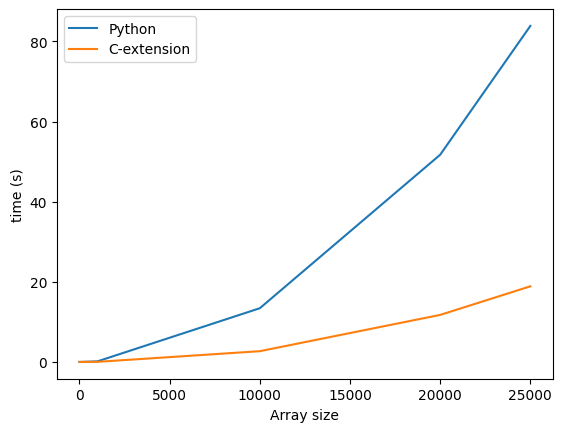

In [7]:
from matplotlib import pyplot as plt


plt.plot(kappas, python_times, label='Python')
plt.plot(kappas, C_times, label='C-extension')

plt.legend()
plt.xlabel("Array size")
plt.ylabel("time (s)")

It is clear to see that the C-extension that we wrote is much faster than the equivalent pure Python version. This is a perfect example of how writing a C-extension can help improve the performance of our network science workflows. In turn, this allows us to study larger networks and push the boundaries of what we can achieve. 

As a final experiment, let us gain some insight into the data serialisation costs associated with initialising the list of integers in the Python codebase, porting it into an array in the C-wrapper before finally creating a vector in the C++ codebase. To do this, we have a second exported entrypoint into the DLL called `largest_component_size_all_integers` which takes a single integer as its argument and creates a std::vector of integers from `1` to `length`.

In [8]:
# Time the C-extension

C_times_all_ints = []
C_results_all_ints = []
for kappa in kappas:

    start = time.time()
    C_results_all_ints.append(brute_dfs_extension.largest_component_size_all_integers(kappa))

    end = time.time()
    C_times_all_ints.append(end - start)
    print(f"Completed kappa = {int(kappa)}")


Completed kappa = 1
Completed kappa = 10
Completed kappa = 100
Completed kappa = 1000
Completed kappa = 10000
Completed kappa = 20000
Completed kappa = 25000


Text(0, 0.5, 'time (s)')

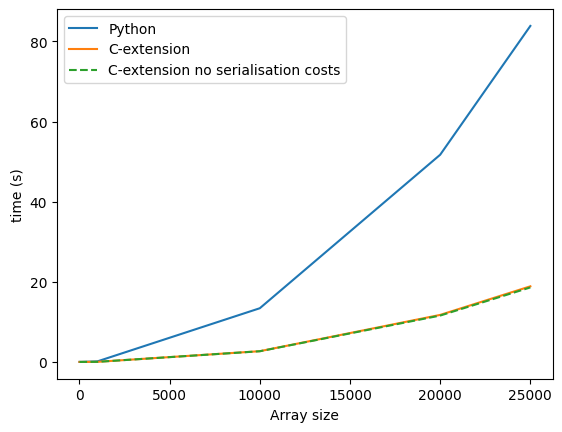

In [9]:
plt.plot(kappas, python_times, label='Python')
plt.plot(kappas, C_times, label='C-extension')
plt.plot(kappas, C_times_all_ints, '--', label='C-extension no serialisation costs')

plt.legend()
plt.xlabel("Array size")
plt.ylabel("time (s)")


In this case, there isn't very much overhead associated with serializing the array into our C layer as the wall-time of both extensions are almost identical. However, this is something that could add precious seconds onto a workflow. If the exported function is within a dense for-loop, or is called many times, these overheads could build up to yield a finite difference. 

# Summary

In this notebook we have learnt how to write C-extensions and call them in a Python codebase. To demonstrate this we implemented a recursive depth first search algorithm of a graph in both pure Python and C++. In our example we found a good increase in the performance of the code by using the C++ implementation.